Xarray version: 2023.1.0
Matplotlib version: 3.6.3
Numpy version: 1.23.5


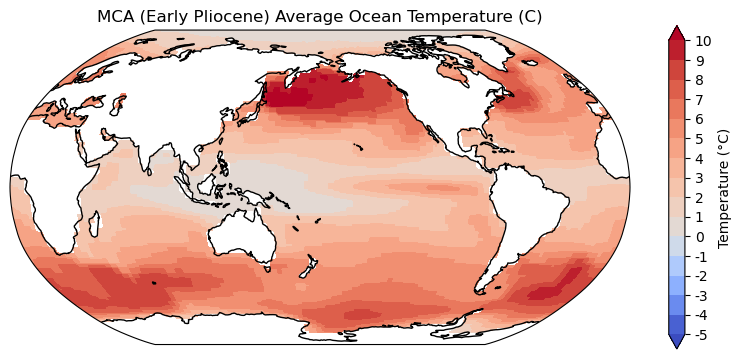

In [2]:
import os  # Module for operating system dependent functionality
import xarray as xr  # Module for working with labeled multidimensional arrays
import matplotlib as mpl  # Module for plotting
import matplotlib.pyplot as plt  # Module for creating plots
import matplotlib.colors as colors  # Module for working with colors in plots
import cartopy.crs as ccrs  # Module for coordinate reference systems
from cartopy.util import add_cyclic_point  # Function for adding cyclic points to data
import numpy as np  # Module for numerical computing
from matplotlib.colors import Normalize  # Class for normalizing colors in plots
import xesmf as xe  # For regridding data
from matplotlib.colors import TwoSlopeNorm

# Print versions of Xarray, Matplotlib, and other relevant modules
print("Xarray version:", xr.__version__)
print("Matplotlib version:", mpl.__version__)
print("Numpy version:", np.__version__)

pi_path = "/glade/u/home/nwrye/OceanTemps_Compiles/Modified_Cloud_Albedo/PreInd_ciso_T31_gx3v7_ALL.2901-3000.nc"
plio_path = '/glade/u/home/nwrye/OceanTemps_Compiles/Modified_Cloud_Albedo/PlioB17_ciso_T31_gx3v7_branch_ALL.2901-3000.nc'

# Define new latitude and longitude arrays
new_lat = np.arange(-90, 90.5, 1)
new_lon = np.arange(0, 360, 1)

# Open the datasets
pi_ds = xr.open_dataset(pi_path)
plio_ds = xr.open_dataset(plio_path)

# Squeeze the datasets to remove singleton dimensions
plio_ds = plio_ds.squeeze()
pi_ds = pi_ds.squeeze()

# Convert z_t variable to meters (divide by 100)
plio_ds["z_t"] = plio_ds["z_t"] * (1 / 100)
pi_ds["z_t"] = pi_ds["z_t"] * (1 / 100)

# Rename variables TLONG and TLAT to lon and lat, respectively
plio_ds = plio_ds.rename({"TLONG": "lon", "TLAT": "lat", "z_t": "lev"})
pi_ds = pi_ds.rename({"TLONG": "lon", "TLAT": "lat", "z_t": "lev"})

# Create a new dataset with desired lat and lon coordinates
plio_ds_out = xr.Dataset({"lat": (["lat"], new_lat), "lon": (["lon"], new_lon)})
pi_ds_out = xr.Dataset({"lat": (["lat"], new_lat), "lon": (["lon"], new_lon)})

# Create a regridder object using the source dataset and the destination dataset
regridder_plio = xe.Regridder(plio_ds, plio_ds_out, "nearest_s2d")
regridder_pi = xe.Regridder(pi_ds, pi_ds_out, "nearest_s2d")

# Regrid the 'TEMP' variable and convert it to datasets
plio_dr_out = regridder_plio(plio_ds["TEMP"]).to_dataset(name="TEMP")
pi_dr_out = regridder_pi(pi_ds["TEMP"]).to_dataset(name="TEMP")

# Define the function to calculate the horizontal temperature difference
def h_diff(plio_regridded, pi_regridded):
    # Calculate the temperature difference between Pliocene and Preindustrial datasets along the latitude axis
    diff = plio_regridded['TEMP'] - pi_regridded['TEMP']
    return diff

# Calculate the temperature difference using regridded datasets
anom_modified_albedo = h_diff(plio_dr_out, pi_dr_out)

# Add lat and lev coordinates to the resulting data array
anom_modified_albedo = anom_modified_albedo.assign_coords(
    {"lat": new_lat, "lev": plio_dr_out.lev, "lon": plio_dr_out.lon})

# Plotting function for the first level of temperature
def plot_projection(X, Y, Z, title, filename):
    """
    Plot data on a map projection for the first level (surface temperature).
    
    Parameters:
    - X: Longitude coordinates of the data.
    - Y: Latitude coordinates of the data.
    - Z: Data values to be plotted (2D array: lat x lon).
    - title: Title of the plot.
    - filename: The filename where the plot should be saved (including extension like '.png', '.jpg', etc.).
    """
    # Define the midpoint value (vcenter), where the slope changes, and the limits
    vmin = -5  # Minimum value
    vmax = 10  # Maximum value
    vcenter = 0  # Midpoint of the colormap

    # Set up the map projection and figure, center the map over the Pacific Ocean
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, figsize=(10, 6))

    # Set the colormap
    cmap = plt.get_cmap('coolwarm')

    # Create TwoSlopeNorm normalization
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    # Add cyclic point to the data for smooth plotting along longitude
    Z_cyclic, X_cyclic = add_cyclic_point(Z, coord=X)

    # Set contour levels explicitly to match the range of the colorbar (-5 to 10)
    levels = np.linspace(vmin, vmax, 16)  # 16 levels for smoother transitions

    # Create the filled contour plot using the TwoSlopeNorm and the explicit levels
    cs = ax.contourf(X_cyclic, Y, Z_cyclic, levels=levels, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,  extend='both')

    # Add coastlines
    ax.coastlines()

    # Set the title of the plot
    ax.set_title(title)

    # Add colorbar with explicit boundaries matching the levels and ticks
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Temperature (°C)', extend='both', shrink=0.7)

    # Manually set the colorbar ticks to range from -5 to 10 with a step of 1
    cbar.set_ticks(np.linspace(vmin, vmax, 16))  # Set ticks from -5 to 10 with 1 step
    cbar.set_ticklabels(np.arange(vmin, vmax + 1, 1))  # Set tick labels to match the tick values

    # Save the plot as a file
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG, JPG, or other formats

    # Show the plot
    plt.show()

# Example call with filename to save the plot
plot_projection(anom_modified_albedo['lon'], anom_modified_albedo['lat'], anom_modified_albedo[0,:,:], 
                'MCA (Early Pliocene) Average Ocean Temperature (C)', 'MCA_Early_Pliocene_Global_SST.pdf')